In [1]:
# ! pip show tensorflow
# ! pip show tensorflow-gpu
# !pip show keras

In [2]:
!pwd

/masvol/heartsmart/unet_model


In [3]:
#import cv2 
import re, sys
import fnmatch, shutil, subprocess
from IPython.utils import io
import glob

import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
import numpy as np
from keras.models import *
from keras.layers import Input, concatenate, merge, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.losses import binary_crossentropy
import keras.backend as K

#Fix the random seeds for numpy (this is for Keras) and for tensorflow backend to reduce the run-to-run variance
from numpy.random import seed
seed(100)
from tensorflow import set_random_seed
set_random_seed(200)

import matplotlib.pyplot as plt
%matplotlib inline

print("\nSuccessfully imported packages!!!\n")


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.



Successfully imported packages!!!



In [4]:
import tensorflow as tf

In [5]:
# config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
# #config.gpu_options.per_process_gpu_memory_fraction = 0.4
# #config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# #sess.run(yourcommand)

In [28]:
#Settings
TRAIN_TEST_SPLIT_RATIO = 0.1  # train/test split ratio for Sunnybrook and ACDC data

BASE_DIR = "/opt/output/"
SOURCE = "sunnybrook"
SB_SOURCE = "sunnybrook"
ACDC_SOURCE = "acdc"
TRAIN_IMG_DIR = BASE_DIR + SOURCE + "/norm/1/3/images/"
TRAIN_LBL_DIR = BASE_DIR + SOURCE + "/norm/1/3/labels/"

TEST_IMG_DIR = BASE_DIR + SOURCE + "/norm/1/3/images/"
PRED_RESULT_DIR = BASE_DIR + SOURCE + "/norm/1/3/images/"

UNET_TRAIN_DIR = BASE_DIR + SOURCE + "/unet_model/data/"
UNET_MODEL_DIR = BASE_DIR + SOURCE + "/unet_model/models/"


UNET_TRAIN_DIR = "/masvol/heartsmart/unet_model/data/"
UNET_MODEL_DIR = "/masvol/heartsmart/unet_model/models/"

# UNET_TRAIN_DIR = "/opt/heartsmart/unet_model/data/"
# UNET_MODEL_DIR = "/opt/heartsmart/unet_model/models/"

DSB_SOURCE = "dsb"
DSB_TRAIN_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/train/"
DSB_VAL_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/validate/"
DSB_TEST_IMG_DIR = BASE_DIR + DSB_SOURCE + "/norm/1/3/test/"



## Methods to process and save DSB2 data set into 4d numpy arrays

In [7]:
############################################
#
# Methods to process and save DSB2 data set into 4d numpy arrays
#
################################################
def crop_center(img,cropx,cropy):
    x,y = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[startx:startx+cropx, starty:starty+cropy]

def pad_image(img, img_size):
    #print ("input shape : ", img.shape)
    pad_x=0
    pad_y=0
    x,y = img.shape
    if (x<img_size):
        pad_x = img_size - x
    if (y<img_size):
        pad_y = img_size - y
    process_img = np.pad(img, pad_width=((pad_x//2, ((pad_x//2) + (pad_x % 2))), (pad_y//2, ((pad_y//2) + (pad_y % 2)))), mode = 'constant', constant_values = 0)
    #print ("output shape : ", process_img.shape)
    return process_img


def shrink_case(case):
    toks = case.split("-")    
    def shrink_if_number(x):
        try:
            cvt = int(x)
            return str(cvt)
        except ValueError:
            return x
    return "-".join([shrink_if_number(t) for t in toks])

class Image_info_map(object):
    def __init__(self, ctr_path):
        self.ctr_path = ctr_path
        #print (ctr_path)
        #/opt/output/dsb/norm/1/3/test/1111/sax_13_IM-2680-0008.dcm.npy
        match = re.search(r"/([^/]*)/sax_(\d+)_IM-(\d+)-(\d+).dcm.npy", ctr_path)
        #match = re.search(r"/([^/]*)/patient\d+_slice(\d+)_frame(\d+)_label_fix.nii.npy", ctr_path)
        try:
            self.case = shrink_case(match.group(1))
            self.sax_num = int (match.group(2))
            self.record = int(match.group(3))
            self.img_no = int(match.group(4))
        except AttributeError:
            #/opt/output/dsb/norm/1/3/train/234/sax_20_IM-3098-0022-0007.dcm.npy
            match = re.search(r"/([^/]*)/sax_(\d+)_IM-(\d+)-(\d+)-(\d+).dcm.npy", ctr_path)
            self.case = shrink_case(match.group(1))
            self.sax_num = int (match.group(2))
            self.record = int(match.group(3))
            self.img_no = int(match.group(5))
            
    def __str__(self):
        return "<Image info for case %s, record %d image %d>" % (self.case, self.record, self.img_no)
    
def get_dsb_image_list2(data_path):
    image_list = [os.path.join(dirpath,f) 
            for files in glob.glob(data_path+"/*") 
            for dirpath, dirname, infiles in os.walk(files) 
            for f in infiles if f.endswith('dcm.npy')]
    
    print("Number of examples: {:d}".format(len(image_list)))
    #print("Shuffle data")
    #np.random.shuffle(image_list)
    print (image_list[0], image_list[-1])
    
    extracted = list(map(Image_info_map, image_list))
    print ("Image 0 :", extracted[0].case, extracted[0].record, extracted[0].img_no)
    print ("Imae -1 :", extracted[-1].case, extracted[-1].record, extracted[-1].img_no) 
    return image_list, extracted

def get_dsb_image_list(data_path):
    image_list = [os.path.join(data_path,files) 
            for files in glob.glob(data_path+"/*") if files.endswith('dcm.npy')]
    
    print("Number of examples: {:d}".format(len(image_list)))
    #print("Shuffle data")
    #np.random.shuffle(image_list)
    print (image_list[0], image_list[-1])
    
    extracted = list(map(Image_info_map, image_list))
    print ("Image 0 :", extracted[0].case, extracted[0].record, extracted[0].img_no)
    print ("Imae -1 :", extracted[-1].case, extracted[-1].record, extracted[-1].img_no) 
    return image_list, extracted

def get_dsb_images(data_path, crop_size):
    print ("data path: ", data_path)
    img_path_list, extracted_info = get_dsb_image_list(data_path)
    img_count = len(img_path_list)
    print("Processing {:d} images and labels...".format(img_count))
    
    imgs , img_path, ext_info = [], [], []
    for i in range(img_count):

        full_path = img_path_list[i]
        img = np.load(full_path)
        x,y = img.shape

        if x < crop_size or y < crop_size:
            #print ("shapes smaller than crop size", x, y, crop_size)
            img = pad_image(img, crop_size)
            #continue
        if x > crop_size or y > crop_size:
            #print ("img: ", i, x, y, full_path)
            img = crop_center(img,crop_size,crop_size)
            
        imgs.append(img)
        img_path.append(full_path)
        ext_info.append(extracted_info[i])

        if i % (img_count//5) == 0:
            print (full_path)
            plt.imshow(img, cmap = 'gray')
            plt.title('Input Image'), plt.xticks([]), plt.yticks([])
            plt.show()

            #except IOError:
            #    continue
    print ("Final size of image set :", len(imgs), "dropped images:", (img_count - len(imgs)))
                
    return imgs, img_path, ext_info

def convert_images_to_nparray_and_save (imgs, save_file, image_size):
    rows = image_size
    cols = image_size
    i = 0
    print('-'*30)
    print("Converting data to np array, Input size : ",len(imgs))
    print('-'*30)
    
    imgdatas = np.ndarray((len(imgs),rows,cols,1), dtype=np.int)
        
    for idx in range(len(imgs)):
        img = imgs[idx]
        img = img_to_array(img)        
        try:
            imgdatas[i] = img
            i += 1
        except Exception as e:
            print (e)
            continue
        
    np.save(save_file, imgdatas)

    print ("Shape of image array : ", imgdatas.shape)
    print ("Max, min, mean values", imgdatas.max(), imgdatas.min(), imgdatas.mean())
    print('Saved data as: ', save_file)



data path:  /opt/output/dsb/norm/1/3/train/204
Number of examples: 240
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy /opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0008.dcm.npy
Image 0 : 204 5940 8
Imae -1 : 204 5943 8
Processing 240 images and labels...
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy


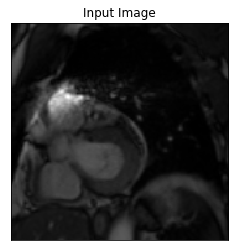

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0006.dcm.npy


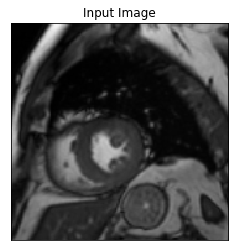

/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0009.dcm.npy


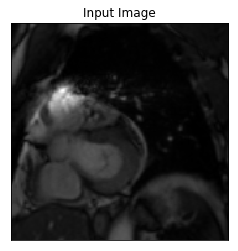

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0005.dcm.npy


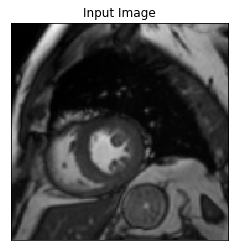

/opt/output/dsb/norm/1/3/train/204/sax_57_IM-5946-0029.dcm.npy


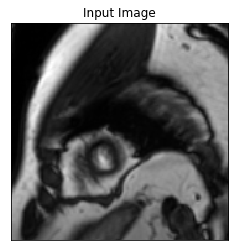

Final size of image set : 240 dropped images: 0
data path:  /opt/output/dsb/norm/1/3/train/204
Number of examples: 240
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy /opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0008.dcm.npy
Image 0 : 204 5940 8
Imae -1 : 204 5943 8
Processing 240 images and labels...
/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0008.dcm.npy


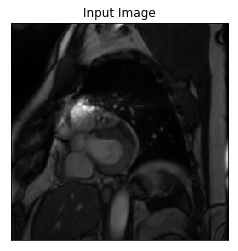

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0006.dcm.npy


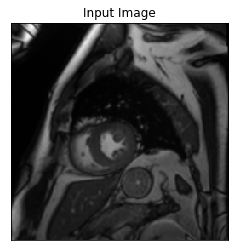

/opt/output/dsb/norm/1/3/train/204/sax_51_IM-5940-0009.dcm.npy


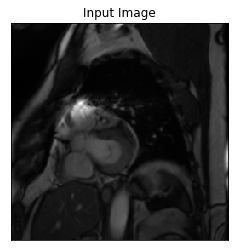

/opt/output/dsb/norm/1/3/train/204/sax_54_IM-5943-0005.dcm.npy


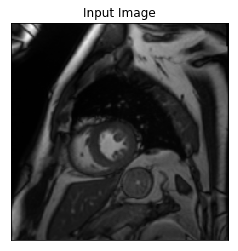

/opt/output/dsb/norm/1/3/train/204/sax_57_IM-5946-0029.dcm.npy


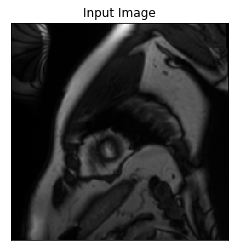

Final size of image set : 240 dropped images: 0
------------------------------
Converting data to np array, Input size :  240
------------------------------
Shape of image array :  (240, 176, 176, 1)
Max, min, mean values 1823 4 212.6733654011708
Saved data as:  /masvol/heartsmart/unet_model/data/dsb204_176.npy
------------------------------
Converting data to np array, Input size :  240
------------------------------
Shape of image array :  (240, 256, 256, 1)
Max, min, mean values 1823 0 202.47705427805582
Saved data as:  /masvol/heartsmart/unet_model/data/dsb204_256.npy


In [24]:
patient_record = "204"
data_path = DSB_TRAIN_IMG_DIR + patient_record
image_list, image_path_list, extracted_info = get_dsb_images(data_path, crop_size=176)
image_list2, image_path_list2, extracted_info2 = get_dsb_images(data_path, crop_size=256)

img_file = UNET_TRAIN_DIR + DSB_SOURCE + patient_record + "_176.npy"
convert_images_to_nparray_and_save (image_list, img_file, image_size = 176)

img_file2 = UNET_TRAIN_DIR + DSB_SOURCE + patient_record + "_256.npy"
convert_images_to_nparray_and_save (image_list2, img_file2, image_size = 256)



## Methods to load 4d np array for images from ./data directory, perform pixel normalization

In [48]:
#########################################
#
# Methods to load 4d np array for images from ./data directory
# 4D tensor with shape: (samples, rows, cols, channels=1)
#
#########################################

def load_images_and_labels(data):
    print('-'*30)
    print('load np arrays of images and labels...')
    print('-'*30)
    imgfile = data["images"]
    labelfile = data["labels"]
    print ("Loading files : ", imgfile, labelfile)
    
    im = np.load(imgfile)
    lb = np.load(labelfile)
    images = im.astype('float32')
    labels = lb.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    print("shape, max, min, mean of labels :", labels.shape, labels.max(), labels.min(), labels.mean())
    return images2, labels


def load_images(imgfile):
    print('-'*30)
    print('load np arrays of images ...')
    print('-'*30)
    print ("Loading files : ", imgfile)
    
    im = np.load(imgfile)
    images = im.astype('float32')
    
    ##Normalize the pixel values, (between 0..1)
    x_min = images.min(axis=(1, 2), keepdims=True)
    x_max = images.max(axis=(1, 2), keepdims=True)
    images2 = (images - x_min)/(x_max-x_min)

    print("shape, max, min, mean of original image set:", images.shape, images.max(), images.min(), images.mean())
    print("shape, max, min, mean after normalization  :", images2.shape, images2.max(), images2.min(), images2.mean())
    return images2

def combine_acdc_sunnybrook_data_176():
    acdc_train_data = {}
    acdc_train_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_train_images.npy"
    acdc_train_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_train_labels.npy"

    acdc_train_img, acdc_train_lbl = load_images_and_labels(acdc_train_data)

    acdc_test_data = {}
    acdc_test_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_test_images.npy"
    acdc_test_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_176_test_labels.npy"

    acdc_test_img, acdc_test_lbl = load_images_and_labels(acdc_test_data)

    sb_train_data = {}
    sb_train_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_train_images.npy"
    sb_train_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_train_labels.npy"
    sb_train_img, sb_train_lbl = load_images_and_labels(sb_train_data)

    sb_test_data = {}
    sb_test_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_test_images.npy"
    sb_test_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_176_test_labels.npy"
    sb_test_img, sb_test_lbl = load_images_and_labels(sb_test_data)

    combined_train_img = np.concatenate((acdc_train_img, sb_train_img), axis=0)
    combined_train_lbl = np.concatenate((acdc_train_lbl, sb_train_lbl), axis=0)

    combined_test_img = np.concatenate((acdc_test_img, sb_test_img), axis=0)
    combined_test_lbl = np.concatenate((acdc_test_lbl, sb_test_lbl), axis=0)
    print (combined_train_img.shape, combined_train_lbl.shape,combined_test_img.shape,combined_test_lbl.shape)
    print ("Saving combined files.......")

    tr_img_file = UNET_TRAIN_DIR + "combined_176_train_images.npy"
    tr_lbl_file = UNET_TRAIN_DIR + "combined_176_train_labels.npy"
    tst_img_file = UNET_TRAIN_DIR + "combined_176_test_images.npy"
    tst_lbl_file = UNET_TRAIN_DIR + "combined_176_test_labels.npy"

    np.save(tr_img_file, combined_train_img)
    np.save(tr_lbl_file, combined_train_lbl)
    np.save(tst_img_file, combined_test_img)
    np.save(tst_lbl_file, combined_test_lbl)
    
def combine_acdc_sunnybrook_data_256():
    acdc_train_data = {}
    acdc_train_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_train_images.npy"
    acdc_train_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_train_labels.npy"

    acdc_train_img, acdc_train_lbl = load_images_and_labels(acdc_train_data)

    acdc_test_data = {}
    acdc_test_data["images"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_test_images.npy"
    acdc_test_data["labels"] = UNET_TRAIN_DIR + ACDC_SOURCE + "_256_test_labels.npy"

    acdc_test_img, acdc_test_lbl = load_images_and_labels(acdc_test_data)

    sb_train_data = {}
    sb_train_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_train_images.npy"
    sb_train_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_train_labels.npy"
    sb_train_img, sb_train_lbl = load_images_and_labels(sb_train_data)

    sb_test_data = {}
    sb_test_data["images"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_test_images.npy"
    sb_test_data["labels"] = UNET_TRAIN_DIR + SB_SOURCE + "_256_test_labels.npy"
    sb_test_img, sb_test_lbl = load_images_and_labels(sb_test_data)

    combined_train_img = np.concatenate((acdc_train_img, sb_train_img), axis=0)
    combined_train_lbl = np.concatenate((acdc_train_lbl, sb_train_lbl), axis=0)

    combined_test_img = np.concatenate((acdc_test_img, sb_test_img), axis=0)
    combined_test_lbl = np.concatenate((acdc_test_lbl, sb_test_lbl), axis=0)
    print (combined_train_img.shape, combined_train_lbl.shape,combined_test_img.shape,combined_test_lbl.shape)
    print ("Saving combined files.......")

    tr_img_file = UNET_TRAIN_DIR + "combined_256_train_images.npy"
    tr_lbl_file = UNET_TRAIN_DIR + "combined_256_train_labels.npy"
    tst_img_file = UNET_TRAIN_DIR + "combined_256_test_images.npy"
    tst_lbl_file = UNET_TRAIN_DIR + "combined_256_test_labels.npy"

    np.save(tr_img_file, combined_train_img)
    np.save(tr_lbl_file, combined_train_lbl)
    np.save(tst_img_file, combined_test_img)
    np.save(tst_lbl_file, combined_test_lbl)

In [51]:
#combine_acdc_sunnybrook_data_176()
#combine_acdc_sunnybrook_data_256()